In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 235 (delta 106), reused 210 (delta 89), pack-reused 0
Receiving objects: 100% (235/235), 30.54 MiB | 31.66 MiB/s, done.
Resolving deltas: 100% (106/106), done.
--2021-12-02 13:32:31--  https://docs.google.com/uc?export=download&confirm=oLsP&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 209.85.200.100, 209.85.200.113, 209.85.200.102, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-2o-docs.googleusercontent.com/docs/securesc/410fd3ru5mulp5fvlg2noruu7pn9vbcq/fh0g5orlli24smq2lcmpo10807qjnks6/1638451950000/06419056966375271799/11100439402219741725Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-12-02 13:32:31--  https://doc-10-2o-docs.go

In [2]:
from dul_2021.utils.hw5_utils import *

# Question 1: VAEs on Images
In this question, you will train VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

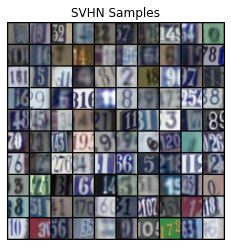

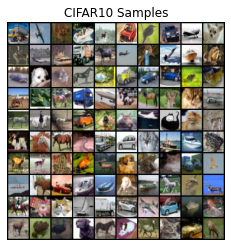

In [3]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [4]:
from typing import List, Dict, Set, Tuple, Optional

from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
import torch
import torch.nn as nn
import torch.optim as optim 

from tqdm.notebook import tqdm
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),  # -> 32 x 32 x 32
            nn.ReLU(), 
            nn.Conv2d(32, 64, 3, 2, 1),  # -> 64 x 16 x 16
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1),  # -> 128 x 8 x 8
            nn.ReLU(), 
            nn.Conv2d(128, 256, 3, 2, 1),  # -> 256 x 4 x 4
            nn.ReLU(), 
            nn.Flatten(), 
            nn.Linear(4 * 4 * 256, 2 * latent_dim)) 

    def forward(self, xs: torch.Tensor) -> torch.Tensor: 
        return self.model(xs.float())

In [7]:
class Decoder(nn.Module): 
    def __init__(self, latent_dim: int): 
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128), 
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, 2, 1),  # -> 128 x 8 x 8 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # -> 64 x 16 x 16
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # -> 32 x 32 x 32
            nn.ReLU(), 
            nn.Conv2d(32, 3, 3, 1, 1))

    def forward(self, zs: torch.Tensor) -> torch.Tensor: 
        out = self.layer1(zs.float())
        out = out.view(len(zs), 128, 4, 4)
        out = self.layer2(out)
        return out

In [8]:
def collate_fn(xs: np.ndarray) -> torch.Tensor: 
    xs = torch.tensor(xs, dtype=torch.float, device=device)
    return xs

In [15]:
class VAE(nn.Module): 
    def __init__(self, latent_dim: int): 
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim) 

        self.p_z = Normal(torch.tensor(0, dtype=float, device=device), 
                          torch.tensor(1, dtype=float, device=device))

    def encode(self, xs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]: 
        encoded = self.encoder(xs)  # batch_size x (2 * latent_dim)
        mu, log_s = encoded.split(self.latent_dim, dim=1)
        return mu, log_s

    def decode(self, zs: torch.Tensor) -> torch.Tensor: 
        return self.decoder(zs)

    def loss(self, xs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size = len(xs)
        mu_z, log_s_z = self.encode(xs)
        zs = self.p_z.sample(mu_z.shape) * log_s_z.exp() + mu_z
        recons = self.decode(zs)

        recon_loss = F.mse_loss(xs, recons, reduction="none").view(batch_size, -1)
        recon_loss = recon_loss.sum(dim=1).mean()

        kld = torch.mean(0.5 * torch.sum((2 * log_s_z).exp() + mu_z ** 2 - log_s_z - 1, dim=1), dim=0)

        return recon_loss, kld

    def sample(self, n_samples: int = 100) -> np.ndarray: 
        self.eval() 

        zs = self.p_z.sample((n_samples, self.latent_dim))
        xs = self.decode(zs)
        return torch.clip(xs, 0, 1).cpu().detach().numpy()

    def test(self, test_loader: DataLoader) -> List[float]: 
        self.eval()

        total_loss = total_kl = total_rec_loss = n_obj = 0

        with torch.no_grad(): 
            for batch in test_loader: 
                recon_loss, kld = self.loss(batch)
                loss = recon_loss + kld

                total_loss += loss.item()
                total_kl += kld.item()
                total_rec_loss += recon_loss.item()
                n_obj += len(batch)

        # return [total_loss / n_obj, total_rec_loss / n_obj, total_kl / n_obj]
        return [total_loss / len(test_loader), 
                total_rec_loss / len(test_loader), 
                total_kl / len(test_loader)]


    def fit(self, train_data: np.ndarray, test_data: np.ndarray, 
            epochs: int = 100, lr: float = 1e-3, batch_size: int = 128) -> Tuple[np.ndarray, np.ndarray]: 
        train_loader = DataLoader(train_data, batch_size=batch_size, 
                                  shuffle=True, collate_fn=collate_fn)
        test_loader = DataLoader(test_data, batch_size=batch_size,
                                  collate_fn=collate_fn)

        optimizer = optim.Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = [self.test(test_loader)]

        for _ in tqdm(range(epochs), "Epochs"): 
            for batch in train_loader: 
                self.train()

                recon_loss, kld = self.loss(batch)
                loss = recon_loss + kld 

                optimizer.zero_grad()
                loss.backward()
                optimizer.step() 

                train_losses.append([loss.item(), recon_loss.item(), kld.item()])
              
            test_losses.append(self.test(test_loader))
              
        return np.array(train_losses), np.array(test_losses)
      
    def reconstruct(self, data: np.ndarray) -> np.ndarray: 
        self.eval()

        data = collate_fn(data)

        with torch.no_grad(): 
            mu_z, log_s = self.encode(data)
            zs = self.p_z.sample(mu_z.shape) * log_s.exp() + mu_z
            recons = torch.clip(self.decode(zs), 0, 1)

        return recons.cpu().detach().numpy()

    def interpolate(self, data: List[Tuple[np.ndarray, np.ndarray]]) -> np.ndarray: 
        self.eval() 

        interpolations = np.zeros((len(data), 10, 3, 32, 32))

        with torch.no_grad(): 
            for i, (img_1, img_2) in enumerate(data): 
                img_1, img_2 = collate_fn([img_1]), collate_fn([img_2])

                mu_1, log_s_1 = self.encode(img_1)
                mu_2, log_s_2 = self.encode(img_2)

                z1 = self.p_z.sample(mu_1.shape) * log_s_1.exp() + mu_1
                z2 = self.p_z.sample(mu_2.shape) * log_s_2.exp() + mu_2

                for j in range(0, 10):
                    alpha = j / 9
                    # mu_z = mu_1 * (1 - alpha) + mu_2 * alpha
                    # log_s = log_s_1 * (1 - alpha) + log_s_2 * alpha
                    # z = self.p_z.sample(mu_z.shape) * log_s.exp() + mu_z

                    z = z1 * (1 - alpha) + z2 * alpha
                    recon = torch.clip(self.decode(z), 0, 1)

                    interpolations[i, j] = recon.cpu().detach().numpy()

        return interpolations.reshape(len(data) * 10, 3, 32, 32)

In [18]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    
    train_data_normed = train_data.transpose(0, 3, 1, 2) / 255.
    test_data_normed = test_data.transpose(0, 3, 1, 2) / 255.

    model = VAE(latent_dim=16).to(device)
    train_losses, test_losses = model.fit(train_data_normed, test_data_normed, epochs=100)
    samples = model.sample(100).transpose(0, 2, 3, 1) * 255.

    out = model.reconstruct(test_data_normed[:50]).transpose(0, 2, 3, 1) * 255.
    recons = np.zeros((100, 32, 32, 3))
    for i in range(50): 
        recons[2 * i] = test_data[i]
        recons[2 * i + 1] = out[i]

    pairs = []
    for i in range(10): 
        pairs.append((test_data_normed[2 * i], test_data_normed[2 * i + 1]))
    inters = model.interpolate(pairs).transpose(0, 2, 3, 1) * 255.

    return train_losses, test_losses, samples, recons, inters

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Final -ELBO: 30.3437, Recon Loss: 21.8110, KL Loss: 8.5327


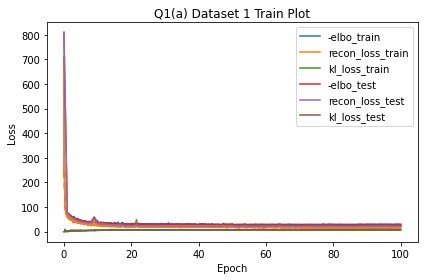

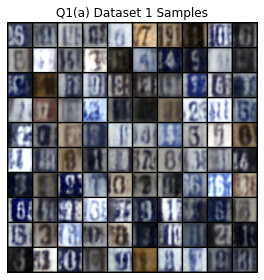

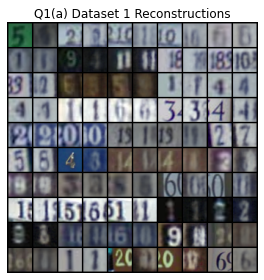

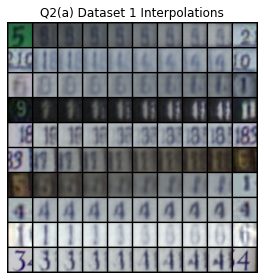

In [20]:
q1_save_results('a', 1, q1_a)